In [5]:
# 1. Import libraries
import pandas as pd
 
# 2. Load dataset
df = pd.read_csv('traffic_volume_dataset.csv', low_memory=False)
 
# 3. Convert startDate to datetime
df['startDate'] = pd.to_datetime(df['startDate'], dayfirst=True, errors='coerce')
 
# 4. Drop rows with invalid or missing dates
df = df.dropna(subset=['startDate'])
 
# 5. Filter for data from 2023 onwards
df = df[df['startDate'].dt.year >= 2023]
 
# 6. Drop irrelevant or high-cardinality columns
df = df.drop(['regionName', 'siteDescription', 'siteReference'], axis=1)
 
# 7. Convert trafficCount to numeric and drop missing
df['trafficCount'] = pd.to_numeric(df['trafficCount'], errors='coerce')
df = df.dropna(subset=['trafficCount'])
 
# 8. Drop rows with missing key features
df = df.dropna(subset=['laneNumber', 'flowDirection', 'classWeight'])
 
# 9. Encode classWeight (low cardinality)
df = pd.get_dummies(df, columns=['classWeight'], drop_first=True)
 
# 10. Extract date features
df['day'] = df['startDate'].dt.day
df['month'] = df['startDate'].dt.month
df['year'] = df['startDate'].dt.year
 
# 11. Drop original startDate column
df = df.drop(['startDate'], axis=1)
 
# 12. Downcast numeric columns to reduce memory usage
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='float')
 
# 13. Optional: Save cleaned dataset
df.to_csv('traffic_volume_cleaned_2023.csv', index=False)
 
# 14. Preview cleaned data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 501376 entries, 9158 to 4617448
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   siteID             501376 non-null  float32
 1   laneNumber         501376 non-null  float32
 2   flowDirection      501376 non-null  float32
 3   trafficCount       501376 non-null  float32
 4   classWeight_Light  501376 non-null  bool   
 5   day                501376 non-null  int32  
 6   month              501376 non-null  int32  
 7   year               501376 non-null  int32  
dtypes: bool(1), float32(4), int32(3)
memory usage: 17.7 MB
None
      siteID  laneNumber  flowDirection  trafficCount  classWeight_Light  day  \
9158     1.0         2.0            2.0         313.0              False    1   
9159     1.0         2.0            2.0        9451.0               True    1   
9160     1.0         1.0            1.0         222.5              False    1   
9161     1.0

In [7]:
# Machine Learning-Based Road Traffic Volume Analysis
# Enhanced with Comprehensive Model Comparison

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import time
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor

# =========================
# 1. Enhanced Data Loading and Preprocessing
# =========================
def load_and_preprocess_data():
    df = pd.read_csv('traffic_volume_dataset.csv', low_memory=False)
    
    # Convert startDate to datetime format
    df['startDate'] = pd.to_datetime(df['startDate'], dayfirst=True, errors='coerce')
    df = df.dropna(subset=['startDate'])
    
    # Filter for data from 2023 onwards
    df = df[df['startDate'].dt.year >= 2023]
    
    # Extract comprehensive date features
    df['day'] = df['startDate'].dt.day
    df['month'] = df['startDate'].dt.month
    df['year'] = df['startDate'].dt.year
    df['day_of_week'] = df['startDate'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['hour'] = df['startDate'].dt.hour
    
    # Drop non-numeric or descriptive columns
    df = df.drop(['startDate', 'regionName', 'siteDescription', 'siteReference'], axis=1)
    
    # Encode categorical variables
    df = pd.get_dummies(df, columns=['classWeight'], drop_first=True)
    
    # Downcast numeric columns to reduce memory usage
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    
    return df

# Load data
df = load_and_preprocess_data()

# Sample data for faster computation
df_sample = df.sample(frac=0.3, random_state=42)

print(f"Dataset shape: {df_sample.shape}")
print(f"Features: {df_sample.columns.tolist()}")

Dataset shape: (150413, 11)
Features: ['siteID', 'laneNumber', 'flowDirection', 'trafficCount', 'day', 'month', 'year', 'day_of_week', 'is_weekend', 'hour', 'classWeight_Light']


In [9]:
# 2. Define Features and Target with Scaling
# =========================
X = df_sample.drop(['trafficCount'], axis=1)
y = df_sample['trafficCount']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for models that benefit from scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# 3. Enhanced Model Definitions
# =========================
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=100),
    'KNeighbors Regressor': KNeighborsRegressor(n_neighbors=5),
    'XGBoost Regressor': XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

In [13]:
# 4. Comprehensive Evaluation Metrics for Regression
# =========================
def calculate_regression_metrics(y_true, y_pred, model_name, fit_time, predict_time):
    """Calculate comprehensive regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100  # Avoid division by zero
    explained_variance = 1 - (np.var(y_true - y_pred) / np.var(y_true))
    
    # Calculate R² adjusted for number of features
    n_samples = len(y_true)
    n_features = X.shape[1]
    r2_adj = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'R²_Adj': r2_adj,
        'MAPE (%)': mape,
        'Explained Variance': explained_variance,
        'Fit Time (s)': fit_time,
        'Predict Time (s)': predict_time
    }

In [15]:
# 5. Enhanced Training and Evaluation with Cross-Validation
# =========================
def evaluate_models_comprehensive(models, X_train, X_test, y_train, y_test, scaled=False):
    """Comprehensive evaluation of all models"""
    results = []
    predictions = {}
    feature_importances = {}
    
    print("Comprehensive Model Evaluation:\n" + "="*70)
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # Select scaled or unscaled data
        if scaled and name in ['Linear Regression', 'KNeighbors Regressor']:
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train, X_test
        
        # Time training
        start_time = time.time()
        model.fit(X_tr, y_train)
        fit_time = time.time() - start_time
        
        # Time prediction
        start_time = time.time()
        y_pred = model.predict(X_te)
        predict_time = time.time() - start_time
        
        # Store predictions
        predictions[name] = y_pred
        
        # Calculate metrics
        metrics = calculate_regression_metrics(y_test, y_pred, name, fit_time, predict_time)
        results.append(metrics)
        
        # Cross-validation scores
        cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='r2')
        metrics['CV R² Mean'] = cv_scores.mean()
        metrics['CV R² Std'] = cv_scores.std()
        
        # Feature importance (if available)
        if hasattr(model, 'feature_importances_'):
            feature_importances[name] = model.feature_importances_
        
        print(f"  R²: {metrics['R²']:.4f}, RMSE: {metrics['RMSE']:.2f}, "
              f"MAE: {metrics['MAE']:.2f}, MAPE: {metrics['MAPE (%)']:.2f}%")
    
    return pd.DataFrame(results), predictions, feature_importances

# Evaluate models
results_df, predictions, feature_importances = evaluate_models_comprehensive(
    models, X_train, X_test, y_train, y_test, scaled=True
)

Comprehensive Model Evaluation:

Evaluating Linear Regression...
  R²: 0.3627, RMSE: 3905.83, MAE: 2559.11, MAPE: 1709.24%

Evaluating Decision Tree...
  R²: 0.8245, RMSE: 2049.57, MAE: 1110.09, MAPE: 1185.10%

Evaluating Random Forest...
  R²: 0.9808, RMSE: 677.73, MAE: 291.01, MAPE: 218.68%

Evaluating Gradient Boosting...
  R²: 0.6910, RMSE: 2719.82, MAE: 1758.00, MAPE: 1290.92%

Evaluating KNeighbors Regressor...
  R²: 0.5180, RMSE: 3396.83, MAE: 2034.27, MAPE: 1452.83%

Evaluating XGBoost Regressor...
  R²: 0.8489, RMSE: 1901.64, MAE: 1152.59, MAPE: 901.64%


In [17]:
# 6. Deep Comparison Analysis
# =========================
def perform_deep_analysis(results_df, predictions, y_test):
    """Perform deep comparative analysis"""
    
    # Sort by R² score
    results_df = results_df.sort_values('R²', ascending=False)
    
    print("\n" + "="*80)
    print("DEEP COMPARATIVE ANALYSIS")
    print("="*80)
    
    # 6.1 Performance Ranking
    print("\n1. PERFORMANCE RANKING (by R² Score):")
    print("-" * 50)
    for i, (_, row) in enumerate(results_df.iterrows(), 1):
        print(f"{i:2d}. {row['Model']:<25} R²: {row['R²']:.4f} | RMSE: {row['RMSE']:.2f} | "
              f"MAE: {row['MAE']:.2f} | MAPE: {row['MAPE (%)']:.2f}%")
    
    # 6.2 Best Model Identification
    best_model_row = results_df.iloc[0]
    print(f"\n2. BEST OVERALL MODEL: {best_model_row['Model']}")
    print(f"   Key Metrics: R² = {best_model_row['R²']:.4f}, "
          f"RMSE = {best_model_row['RMSE']:.2f}, "
          f"MAPE = {best_model_row['MAPE (%)']:.2f}%")
    
    # 6.3 Statistical Significance Testing (simplified)
    print("\n3. STATISTICAL COMPARISON:")
    print("-" * 50)
    best_pred = predictions[best_model_row['Model']]
    for model_name, pred in predictions.items():
        if model_name != best_model_row['Model']:
            # Calculate improvement over other models
            other_r2 = r2_score(y_test, pred)
            improvement = (best_model_row['R²'] - other_r2) * 100
            print(f"   {best_model_row['Model']} vs {model_name:<20}: "
                  f"+{improvement:+.2f}% R² improvement")
    
    # 6.4 Computational Efficiency Analysis
    print("\n4. COMPUTATIONAL EFFICIENCY:")
    print("-" * 50)
    fastest_fit = results_df.loc[results_df['Fit Time (s)'].idxmin()]
    fastest_predict = results_df.loc[results_df['Predict Time (s)'].idxmin()]
    
    print(f"   Fastest Training: {fastest_fit['Model']} ({fastest_fit['Fit Time (s)']:.3f}s)")
    print(f"   Fastest Prediction: {fastest_predict['Model']} ({fastest_predict['Predict Time (s)']:.3f}s)")
    
    # 6.5 Stability Analysis (CV results)
    print("\n5. MODEL STABILITY (Cross-Validation):")
    print("-" * 50)
    most_stable = results_df.loc[results_df['CV R² Std'].idxmin()]
    print(f"   Most Stable: {most_stable['Model']} (CV Std: {most_stable['CV R² Std']:.4f})")
    
    return results_df

# Perform deep analysis
results_df = perform_deep_analysis(results_df, predictions, y_test)


DEEP COMPARATIVE ANALYSIS

1. PERFORMANCE RANKING (by R² Score):
--------------------------------------------------
 1. Random Forest             R²: 0.9808 | RMSE: 677.73 | MAE: 291.01 | MAPE: 218.68%
 2. XGBoost Regressor         R²: 0.8489 | RMSE: 1901.64 | MAE: 1152.59 | MAPE: 901.64%
 3. Decision Tree             R²: 0.8245 | RMSE: 2049.57 | MAE: 1110.09 | MAPE: 1185.10%
 4. Gradient Boosting         R²: 0.6910 | RMSE: 2719.82 | MAE: 1758.00 | MAPE: 1290.92%
 5. KNeighbors Regressor      R²: 0.5180 | RMSE: 3396.83 | MAE: 2034.27 | MAPE: 1452.83%
 6. Linear Regression         R²: 0.3627 | RMSE: 3905.83 | MAE: 2559.11 | MAPE: 1709.24%

2. BEST OVERALL MODEL: Random Forest
   Key Metrics: R² = 0.9808, RMSE = 677.73, MAPE = 218.68%

3. STATISTICAL COMPARISON:
--------------------------------------------------
   Random Forest vs Linear Regression   : ++61.81% R² improvement
   Random Forest vs Decision Tree       : ++15.63% R² improvement
   Random Forest vs Gradient Boosting   : ++2

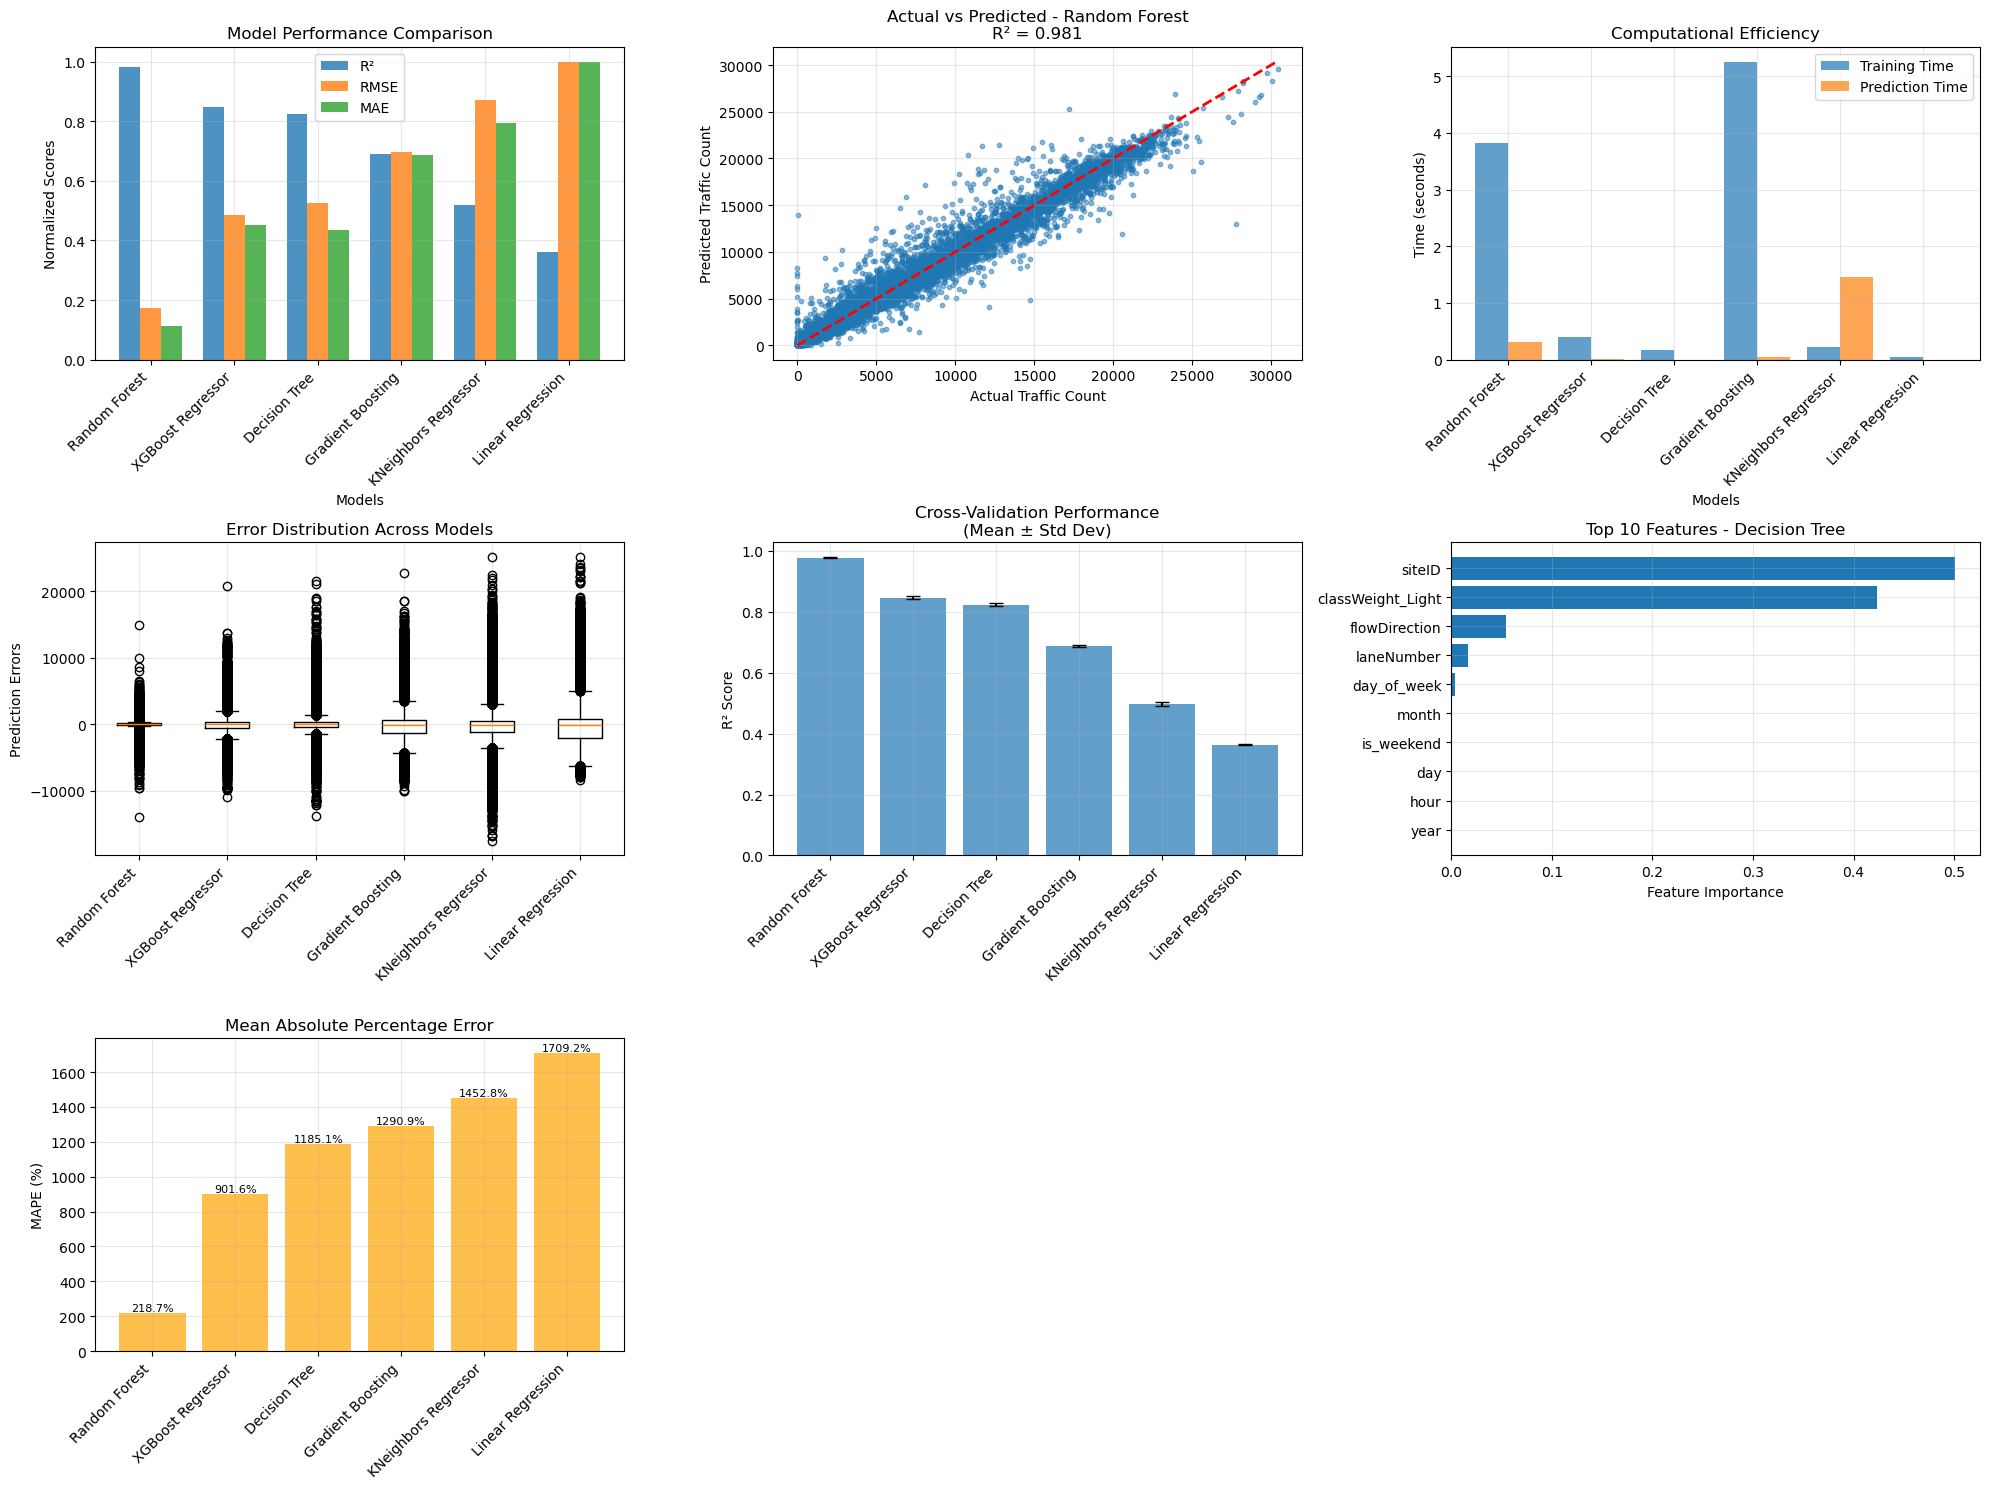

In [19]:
# 7. Comprehensive Visualization
# =========================
def create_comprehensive_visualizations(results_df, predictions, y_test, feature_importances):
    """Create comprehensive comparison visualizations"""
    
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    # 7.1 Performance Metrics Comparison
    plt.subplot(3, 3, 1)
    metrics_to_plot = ['R²', 'RMSE', 'MAE']
    x_pos = np.arange(len(results_df))
    width = 0.25
    
    for i, metric in enumerate(metrics_to_plot):
        values = results_df[metric].values
        if metric == 'RMSE' or metric == 'MAE':
            values = values / np.max(values)  # Normalize for comparison
        plt.bar(x_pos + i*width, values, width, label=metric, alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Normalized Scores')
    plt.title('Model Performance Comparison')
    plt.xticks(x_pos + width, results_df['Model'], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7.2 Actual vs Predicted for Best Model
    plt.subplot(3, 3, 2)
    best_model_name = results_df.iloc[0]['Model']
    best_pred = predictions[best_model_name]
    
    plt.scatter(y_test, best_pred, alpha=0.5, s=10)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Traffic Count')
    plt.ylabel('Predicted Traffic Count')
    plt.title(f'Actual vs Predicted - {best_model_name}\nR² = {results_df.iloc[0]["R²"]:.3f}')
    plt.grid(True, alpha=0.3)
    
    # 7.3 Computational Efficiency
    plt.subplot(3, 3, 3)
    models_list = results_df['Model'].values
    fit_times = results_df['Fit Time (s)'].values
    predict_times = results_df['Predict Time (s)'].values
    
    x_pos = np.arange(len(models_list))
    plt.bar(x_pos - 0.2, fit_times, 0.4, label='Training Time', alpha=0.7)
    plt.bar(x_pos + 0.2, predict_times, 0.4, label='Prediction Time', alpha=0.7)
    plt.xlabel('Models')
    plt.ylabel('Time (seconds)')
    plt.title('Computational Efficiency')
    plt.xticks(x_pos, models_list, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7.4 Error Distribution
    plt.subplot(3, 3, 4)
    errors = {}
    for model_name, pred in predictions.items():
        errors[model_name] = y_test - pred
    
    plt.boxplot([errors[model] for model in models_list], labels=models_list)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Prediction Errors')
    plt.title('Error Distribution Across Models')
    plt.grid(True, alpha=0.3)
    
    # 7.5 Cross-Validation Performance
    plt.subplot(3, 3, 5)
    cv_means = results_df['CV R² Mean'].values
    cv_stds = results_df['CV R² Std'].values
    
    plt.bar(range(len(models_list)), cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
    plt.xticks(range(len(models_list)), models_list, rotation=45, ha='right')
    plt.ylabel('R² Score')
    plt.title('Cross-Validation Performance\n(Mean ± Std Dev)')
    plt.grid(True, alpha=0.3)
    
    # 7.6 Feature Importance (for tree-based models)
    if feature_importances:
        plt.subplot(3, 3, 6)
        model_with_importance = list(feature_importances.keys())[0]
        importance_values = feature_importances[model_with_importance]
        feature_names = X.columns
        
        # Get top 10 features
        indices = np.argsort(importance_values)[-10:]
        plt.barh(range(len(indices)), importance_values[indices])
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 10 Features - {model_with_importance}')
        plt.grid(True, alpha=0.3)
    
    # 7.7 MAPE Comparison
    plt.subplot(3, 3, 7)
    mape_values = results_df['MAPE (%)'].values
    bars = plt.bar(range(len(models_list)), mape_values, color='orange', alpha=0.7)
    plt.xticks(range(len(models_list)), models_list, rotation=45, ha='right')
    plt.ylabel('MAPE (%)')
    plt.title('Mean Absolute Percentage Error')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, mape_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{value:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
create_comprehensive_visualizations(results_df, predictions, y_test, feature_importances)

In [21]:
# 8. Detailed Results Table
# =========================
print("\n" + "="*100)
print("DETAILED PERFORMANCE METRICS")
print("="*100)

# Format results for better display
display_columns = ['Model', 'R²', 'R²_Adj', 'RMSE', 'MAE', 'MAPE (%)', 
                  'CV R² Mean', 'CV R² Std', 'Fit Time (s)', 'Predict Time (s)']

formatted_results = results_df[display_columns].copy()
formatted_results[['R²', 'R²_Adj', 'CV R² Mean', 'CV R² Std']] = formatted_results[['R²', 'R²_Adj', 'CV R² Mean', 'CV R² Std']].round(4)
formatted_results[['RMSE', 'MAE']] = formatted_results[['RMSE', 'MAE']].round(2)
formatted_results[['MAPE (%)']] = formatted_results[['MAPE (%)']].round(2)
formatted_results[['Fit Time (s)', 'Predict Time (s)']] = formatted_results[['Fit Time (s)', 'Predict Time (s)']].round(4)

print(formatted_results.to_string(index=False))


DETAILED PERFORMANCE METRICS
               Model     R²  R²_Adj    RMSE     MAE  MAPE (%)  CV R² Mean  CV R² Std  Fit Time (s)  Predict Time (s)
       Random Forest 0.9808  0.9808  677.73  291.01    218.68      0.9776     0.0014        3.8133            0.3138
   XGBoost Regressor 0.8489  0.8489 1901.64 1152.59    901.64      0.8470     0.0035        0.3991            0.0121
       Decision Tree 0.8245  0.8244 2049.57 1110.09   1185.10      0.8236     0.0041        0.1637            0.0000
   Gradient Boosting 0.6910  0.6909 2719.82 1758.00   1290.92      0.6885     0.0036        5.2549            0.0440
KNeighbors Regressor 0.5180  0.5178 3396.83 2034.27   1452.83      0.4964     0.0071        0.2175            1.4648
   Linear Regression 0.3627  0.3625 3905.83 2559.11   1709.24      0.3639     0.0017        0.0389            0.0000


In [23]:
# 9. Model Recommendations
# =========================
print("\n" + "="*80)
print("MODEL RECOMMENDATIONS")
print("="*80)

best_overall = results_df.iloc[0]
best_fast_training = results_df.loc[results_df['Fit Time (s)'].idxmin()]
best_fast_prediction = results_df.loc[results_df['Predict Time (s)'].idxmin()]
most_stable = results_df.loc[results_df['CV R² Std'].idxmin()]

print(f"🏆 Best Overall Performance: {best_overall['Model']}")
print(f"   - R²: {best_overall['R²']:.4f}, RMSE: {best_overall['RMSE']:.2f}")
print(f"   - Use when: Maximum accuracy is required")

print(f"\n⚡ Fastest Training: {best_fast_training['Model']}")
print(f"   - Training Time: {best_fast_training['Fit Time (s)']:.4f}s")
print(f"   - Use when: Rapid model development is needed")

print(f"\n🎯 Fastest Prediction: {best_fast_prediction['Model']}")
print(f"   - Prediction Time: {best_fast_prediction['Predict Time (s)']:.4f}s")
print(f"   - Use when: Real-time predictions are required")

print(f"\n🛡️ Most Stable: {most_stable['Model']}")
print(f"   - CV Std: {most_stable['CV R² Std']:.4f}")
print(f"   - Use when: Consistent performance across different data splits is crucial")


MODEL RECOMMENDATIONS
🏆 Best Overall Performance: Random Forest
   - R²: 0.9808, RMSE: 677.73
   - Use when: Maximum accuracy is required

⚡ Fastest Training: Linear Regression
   - Training Time: 0.0389s
   - Use when: Rapid model development is needed

🎯 Fastest Prediction: Decision Tree
   - Prediction Time: 0.0000s
   - Use when: Real-time predictions are required

🛡️ Most Stable: Random Forest
   - CV Std: 0.0014
   - Use when: Consistent performance across different data splits is crucial



RESIDUAL ANALYSIS FOR BEST MODEL


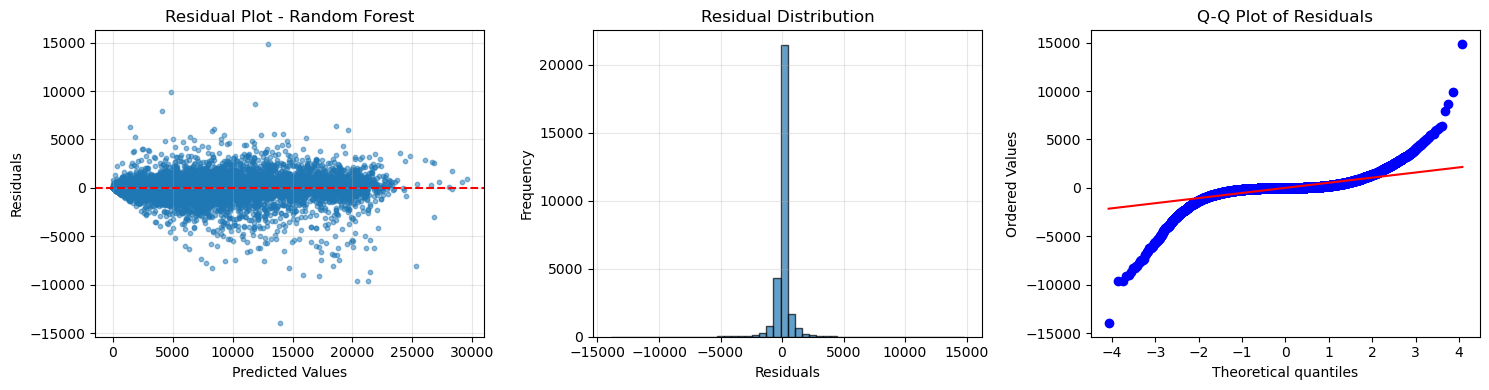

Residual Statistics:
  Mean: 10.45 (should be close to 0)
  Standard Deviation: 677.65
  Normality test (p-value): 0.0000

✅ Comprehensive model comparison completed!


In [25]:
# 10. Residual Analysis for Best Model
# =========================
print("\n" + "="*80)
print("RESIDUAL ANALYSIS FOR BEST MODEL")
print("="*80)

best_model_name = best_overall['Model']
best_pred = predictions[best_model_name]
residuals = y_test - best_pred

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.scatter(best_pred, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residual Plot - {best_model_name}')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Calculate residual statistics
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)
print(f"Residual Statistics:")
print(f"  Mean: {residual_mean:.2f} (should be close to 0)")
print(f"  Standard Deviation: {residual_std:.2f}")
print(f"  Normality test (p-value): {stats.normaltest(residuals).pvalue:.4f}")

print("\n✅ Comprehensive model comparison completed!")